In [2]:
import ml
reload(ml)
from ml import *
import timeit
import scipy
import operator
import collections
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from __future__ import division
from matplotlib.colors import ListedColormap
import statsmodels.api as sm
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.ensemble import AdaBoostClassifier as ADB
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.tree import DecisionTreeClassifier as CART
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.manifold.t_sne import TSNE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

In [ ]:
# Lender Experience
# Borrower Experience

borrower_features = ["DebtToIncomeRatio", "BorrowerAge", "BorrowerSuccessRate", "AvailableBankcardCredit", 
                     "BankDraftFeeAnnualRate", "BorrowerMaximumRate", "CreditGrade",
                     "CreditScoreRangeLower", "CreditScoreRangeUpper", "DebtToIncomeRatio", "EffectiveYield", 
                     "IsBorrowerHomeowner", "OnTimeProsperPayments", "ProsperPaymentsLessThanOneMonthLate",
                     "ProsperPaymentsOneMonthPlusLate", "ProsperScore", "TotalInquiries", "TotalProsperLoans",
                     "TotalProsperPaymentsBilled", "TradesOpenedLast6Months", ]

lender_features = ["NoLenders", "MedianLenderAge", "MedianLenderSuccessRate"]

loan_features = ["MedianEstimatedLoss", "MedianEstimatedReturn", "MedianLenderRate", "MedianLenderYield", 
                 "MedianMonthlyLoanPayment", "TotalMonthlyLoanPayment",
                 "MedianTerm", "MedianAgeInMonths", "TotalAmountBorrowed", "MedianBorrowerRate", ]

listing_features = ["ListingKey", "Category", "AmountRequested", "BidCount",
                    "BidMaximumRate", 
                    "ProsperPrincipalBorrowed", "ProsperPrincipalOutstanding",
                    "TimeToFirstBid", "AvgInterBidTime", "TimeToCompletion",
                    "Gini", "DescriptionLength", "FundedOrNot", "RepaidOrNot"]

## Bid Data

In [22]:
bid_data = pd.read_csv('../Data/bid_notick.txt', sep="|")
bid_data = bid_data[["Bid_Key", "Amount","CreationDate","ListingKey","ListingStatus"]]
bid_data= bid_data.rename(index=str, columns={"Bid_Key": "BidKey", "Amount": "BidAmount", "CreationDate": "BidCreationDate", "ListingKey": "ListingKey", "ListingStatus": "ListingStatus"})
bid_data = bid_data.loc[(bid_data["ListingStatus"]=="Cancelled") | (bid_data["ListingStatus"]=="Expired") | (bid_data["ListingStatus"]=="Withdrawn") | (bid_data["ListingStatus"]=="Completed")]
bid_data = bid_data.loc[bid_data["BidAmount"]>0]
bid_data["FundedOrNot"] = bid_data["ListingStatus"]=="Completed"
bid_data.sample(10)

,BidKey,BidAmount,BidCreationDate,ListingKey,ListingStatus,FundedOrNot
834207,768233808394389665E9C45,100.000,2007-01-26 19:18:40,382E33790838967339B702D,Withdrawn,False
6486007,1FBF3597282299891157D3E,25.000,2010-09-04 00:31:19,354B34666225330458DFBCC,Completed,True
5379877,D2D73532140975042656869,50.000,2008-07-31 06:47:27,CBAD342768868264155F891,Completed,True
7588736,9F123600752845518C234DB,50.000,2010-10-18 16:21:04,81F33497367616052AF5F71,Expired,False
6687773,667335800230541869A9BFD,25.000,2010-02-03 16:07:42,79623476031820214B60149,Withdrawn,False
6843318,165D358385939656496355F,25.000,2010-03-21 17:17:38,9D333478739051793537DD8,Completed,True
7998013,C71A3611769021497A3B4C2,25.000,2011-02-17 09:35:21,8C3C3507384769099B99B7F,Completed,True
247671,475C337218307399526CA9E,131.520,2006-10-17 08:38:08,184C33710043804832AFA5D,Completed,True
5548591,93033532522464125B373FF,50.000,2008-08-23 12:39:11,4F74342967048364413E83B,Expired,False
1808773,3A2A3495762125042958AA6,50.000,2007-06-11 07:02:09,AD773390764731906C1E14A,Completed,True


## Listing Data

In [23]:
listing_data = pd.read_csv('../Data/listing.txt', sep="|")
listing_data = listing_data[["Lst_Key", "ActiveProsperLoans", "BidCount", "BidMaximumRate", "AmountRequested","CreationDate", 
                             "BorrowerRate", "BorrowerMaximumRate", "EffectiveYield", "BorrowerState","CreditGrade",
                             "DebtToIncomeRatio", "EstimatedReturn", "EstimatedLoss", "IsBorrowerHomeowner", "Category",
                             "LenderRate", "LenderYield", "TotalProsperLoans", "MonthlyLoanPayment", "OnTimeProsperPayments",
                             "ProsperScore"]]
listing_data = listing_data.rename(index=str, columns={"Lst_Key": "ListingKey", "AmountRequested": "AmountRequested", "CreationDate": "ListingStartDate"})
listing_data.sample(5)

,ListingKey,ActiveProsperLoans,BidCount,BidMaximumRate,AmountRequested,ListingStartDate,BorrowerRate,BorrowerMaximumRate,EffectiveYield,BorrowerState,...,EstimatedReturn,EstimatedLoss,IsBorrowerHomeowner,Category,LenderRate,LenderYield,TotalProsperLoans,MonthlyLoanPayment,OnTimeProsperPayments,ProsperScore
243685,70BB34113250534278584D3,nan,0,0.083,25000.000,2008-02-04 13:09:20,0.083,0.083,nan,TN,...,nan,nan,False,1,0.083,0.073,nan,787.220,nan,nan
414291,988535415072061878B7A4A,nan,238,0.245,12000.000,2012-03-04 14:05:28,0.245,0.245,nan,WY,...,nan,0.119,True,1,0.245,0.235,nan,474.080,nan,5.000
99016,63D73385935843251E8CDC9,nan,0,0.180,3600.000,2007-04-07 10:39:47,0.200,0.200,nan,LA,...,nan,nan,False,0,0.180,0.170,nan,130.150,nan,nan
26834,649933749180397621E926F,nan,0,0.150,7500.000,2006-11-26 13:11:43,0.150,0.150,nan,NJ,...,nan,nan,False,0,0.150,0.145,nan,259.990,nan,nan
338115,6E283431980280951EC10C8,nan,1,0.087,6000.000,2008-10-01 07:02:09,0.087,0.087,nan,TX,...,nan,nan,True,1,0.087,0.077,nan,189.990,nan,nan


## Loan Data

In [24]:
loan_data = pd.read_csv('../Data/loan.txt', sep="|")
loan_data = loan_data[["Status","ListingKey","CreationDate"]]
loan_data = loan_data.rename(index=str, columns={"Status": "LoanStatus", "ListingKey": "ListingKey", "CreationDate": "LoanCreationDate"})
loan_data = loan_data.loc[(loan_data["LoanStatus"]=="Paid") | 
                          (loan_data["LoanStatus"]=="Defaulted (Bankruptcy)") |
                          (loan_data["LoanStatus"]=="Defaulted (Delinquency)") |
                          (loan_data["LoanStatus"]=="Defaulted (PaidInFull)") |
                          (loan_data["LoanStatus"]=="Defaulted (SettledInFull)")]
loan_data['RepaidOrNot'] = loan_data["LoanStatus"]=="Paid"
loan_data.sample(10)

,LoanStatus,ListingKey,LoanCreationDate,RepaidOrNot
7871,Paid,C57633816363215341D671C,2007-02-27 13:08:25,True
28867,Paid,005E34322485488846533C2,2008-10-05 12:04:55,True
209,Paid,E50B3364462986726F7109A,2006-03-12 05:30:28,True
21903,Defaulted (Bankruptcy),C87234195715749761B099F,2008-04-28 11:48:54,False
8418,Paid,5E0B3382381065449D8D854,2007-03-11 14:36:52,True
15684,Paid,3BFF3403339562184690245,2007-10-24 12:38:15,True
15847,Paid,6AA034040095615406D5D07,2007-11-02 15:44:54,True
3059,Paid,8208336698431401115EAC9,2006-08-31 14:50:13,True
39993,Paid,45E835143031253946382DB,2011-06-03 17:48:40,True
31802,Paid,B1023474784771552D57270,2010-02-22 08:29:43,True


## Merge Data

In [25]:
data = bid_data.merge(listing_data, on="ListingKey")
data = data.merge(loan_data, on="ListingKey", how="outer")
data = data[data.FundedOrNot == True]

del bid_data
del listing_data
del loan_data

data.sample(10)

,BidKey,BidAmount,BidCreationDate,ListingKey,ListingStatus,FundedOrNot,ActiveProsperLoans,BidCount,BidMaximumRate,AmountRequested,...,Category,LenderRate,LenderYield,TotalProsperLoans,MonthlyLoanPayment,OnTimeProsperPayments,ProsperScore,LoanStatus,LoanCreationDate,RepaidOrNot
4307456,EF98352254289699335ADBC,50.000,2008-04-21 19:49:30,BEB33417977857162A25230,Completed,True,nan,57,0.173,1000.000,...,4,0.174,0.164,nan,35.850,nan,7.000,Paid,2008-04-22 07:58:21,True
2657504,D88B35073179969598C5B76,50.000,2007-10-16 11:24:00,8AD83402488628619B8B590,Completed,True,nan,169,0.146,3000.000,...,0,0.146,0.136,nan,103.470,nan,1.000,Paid,2007-10-16 13:39:12,True
6620316,D8FA3577595990043151AE0,25.000,2010-01-15 16:08:33,75BE3473261853397467B0A,Withdrawn,False,nan,349,0.149,8000.000,...,1,0.150,0.140,nan,277.320,nan,8.000,NaN,NaN,NaN
5289099,BCBD353103359843178CBBA,50.000,2008-07-23 07:47:26,6145342734941979683ACEF,Completed,True,nan,748,0.161,19000.000,...,1,0.162,0.151,nan,669.390,nan,7.000,Paid,2008-07-25 17:08:01,True
620069,AA453378199449182ECFBB8,59.100,2006-12-26 15:55:34,AE82337608201147223E090,Completed,True,nan,783,0.123,25000.000,...,0,0.123,0.118,nan,840.540,nan,nan,Paid,2007-01-10 13:40:40,True
944020,C4943381466908664895C36,50.000,2007-02-20 04:14:18,544D3381587420440AC8879,Expired,False,nan,37,0.095,4500.000,...,0,0.095,0.090,nan,144.150,nan,nan,NaN,NaN,NaN
8486682,372536199610809759F985B,27.000,2011-05-29 15:33:49,C09635177040196453B1D95,Completed,True,1.000,97,0.189,4500.000,...,2,0.190,0.180,1.000,164.930,6.000,5.000,NaN,NaN,NaN
4375884,0B8F3522334077870927244,50.000,2008-04-24 16:54:11,8BF63419701192085119F0D,Cancelled,False,nan,703,0.169,25000.000,...,3,0.170,0.160,nan,890.700,nan,nan,NaN,NaN,NaN
930648,39FF3381525055075AF96C6,50.000,2007-02-12 16:21:02,7DB1338090958290365B3F0,Completed,True,nan,52,0.187,7000.000,...,0,0.187,0.182,nan,194.300,nan,4.000,Paid,2007-02-23 16:26:53,True
2081388,B2F73498217792856F461D8,50.000,2007-07-18 09:07:50,1EA733952225358437DF4EB,Expired,False,nan,59,0.110,7000.000,...,0,0.110,0.105,nan,229.140,nan,nan,NaN,NaN,NaN


In [31]:
print ("Dataset dimension: {0}".format(data.shape))
print ("\nDataset contains {0} features: {1}.".format(len(data.columns), data.columns))
print "\nTotal Listings: ", len(set(data.ListingKey))
print "\nTotal Bids: ", len(set(data.BidKey))
print ("\nListing Status:")
print Counter(data.ListingStatus)
print ("\nFunding Status:")
print Counter(data.FundedOrNot)
print ("\nPercentage Funded: ")
print (dict(Counter(data.FundedOrNot))[True] / len(data)) * 100
print ("\nRepayment Status:")
print Counter(data.loc[data['FundedOrNot']==True]['RepaidOrNot'])
print ("\nPercentage Repaid:")
print (dict(Counter(data.loc[data['FundedOrNot']==True]['RepaidOrNot']))[True] / len(data.loc[data['FundedOrNot']==True])) * 100

Dataset dimension: (9702715, 30)

Dataset contains 30 features: Index([u'BidKey', u'BidAmount', u'BidCreationDate', u'ListingKey',
       u'ListingStatus', u'FundedOrNot', u'ActiveProsperLoans', u'BidCount',
       u'BidMaximumRate', u'AmountRequested', u'ListingStartDate',
       u'BorrowerRate', u'BorrowerMaximumRate', u'EffectiveYield',
       u'BorrowerState', u'CreditGrade', u'DebtToIncomeRatio',
       u'EstimatedReturn', u'EstimatedLoss', u'IsBorrowerHomeowner',
       u'Category', u'LenderRate', u'LenderYield', u'TotalProsperLoans',
       u'MonthlyLoanPayment', u'OnTimeProsperPayments', u'ProsperScore',
       u'LoanStatus', u'LoanCreationDate', u'RepaidOrNot'],
      dtype='object').

Total Listings:  235753

Total Bids:  9702715

Listing Status:
Counter({'Completed': 6300999, 'Cancelled': 1332168, 'Expired': 1297213, 'Withdrawn': 772335})

Funding Status:
Counter({True: 6300999, False: 3401716})

Percentage Funded: 
64.940575911

Repayment Status:
Counter({True: 3090657, nan

## Summary Statistics

In [7]:
data.describe()

,BidAmount,ActiveProsperLoans,BidCount,BidMaximumRate,AmountRequested,BorrowerRate,BorrowerMaximumRate,EffectiveYield,DebtToIncomeRatio,EstimatedReturn,EstimatedLoss,Category,LenderRate,LenderYield,TotalProsperLoans,MonthlyLoanPayment,OnTimeProsperPayments,ProsperScore
count,9702715.000,746657.000,9702715.000,9702715.000,9702715.000,9702715.000,9702715.000,66550.000,9099466.000,66550.000,7026699.000,9702715.000,9702715.000,9702715.000,746657.000,9702715.000,746657.000,7026742.000
mean,79.562,0.598,232.642,0.176,10736.645,0.177,0.203,0.199,0.303,0.110,0.113,1.970,0.176,0.167,1.257,372.162,19.896,6.126
std,240.362,0.490,194.621,0.073,7066.928,0.073,0.077,0.066,0.782,0.028,0.091,2.448,0.073,0.073,0.575,243.828,15.570,2.612
min,0.010,0.000,1.000,0.000,1000.000,0.000,0.000,0.051,0.000,0.031,0.006,0.000,0.000,-0.010,1.000,0.000,0.000,1.000
25%,47.730,0.000,86.000,0.118,5000.000,0.119,0.143,0.190,0.130,0.101,0.042,0.000,0.118,0.110,1.000,177.010,9.000,4.000
50%,50.000,1.000,180.000,0.159,9000.000,0.160,0.193,0.190,0.200,0.101,0.089,1.000,0.160,0.150,1.000,317.350,15.000,6.000
75%,74.750,1.000,329.000,0.220,15000.000,0.225,0.264,0.231,0.310,0.142,0.160,3.000,0.221,0.214,1.000,518.080,29.000,8.000
max,25000.000,1.000,1206.000,0.500,25000.000,0.500,0.500,0.290,10.010,0.143,0.380,20.000,0.500,0.495,7.000,1141.540,103.000,10.000


## Correlation Matrix

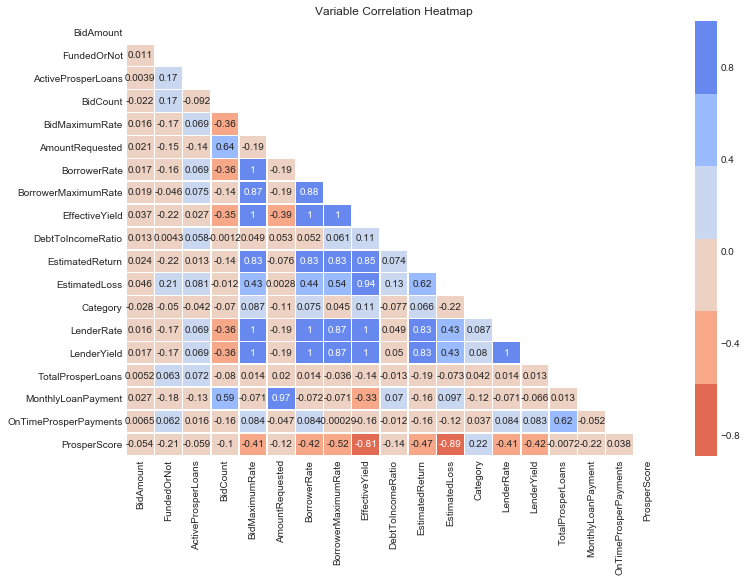

In [8]:
corr = data.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12,8))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("coolwarm_r"),
        mask = mask,
        linewidths=.5,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

## Listing Status

ListingStatus
Cancelled    1332168
Completed    6300999
Expired      1297213
Withdrawn    772335 
dtype: int64


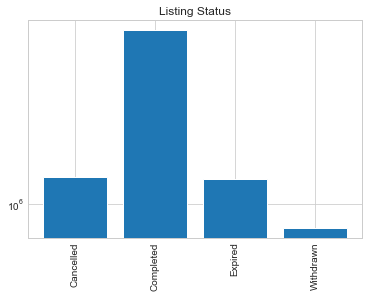

In [9]:
print data.groupby('ListingStatus').size()
listing_labels = sorted(data.groupby('ListingStatus').groups.keys())
plt.bar(listing_labels, 
        data.groupby('ListingStatus').size())
plt.yscale('log')
plt.xticks(range(4), listing_labels, rotation='vertical')
plt.title('Listing Status')
plt.show()

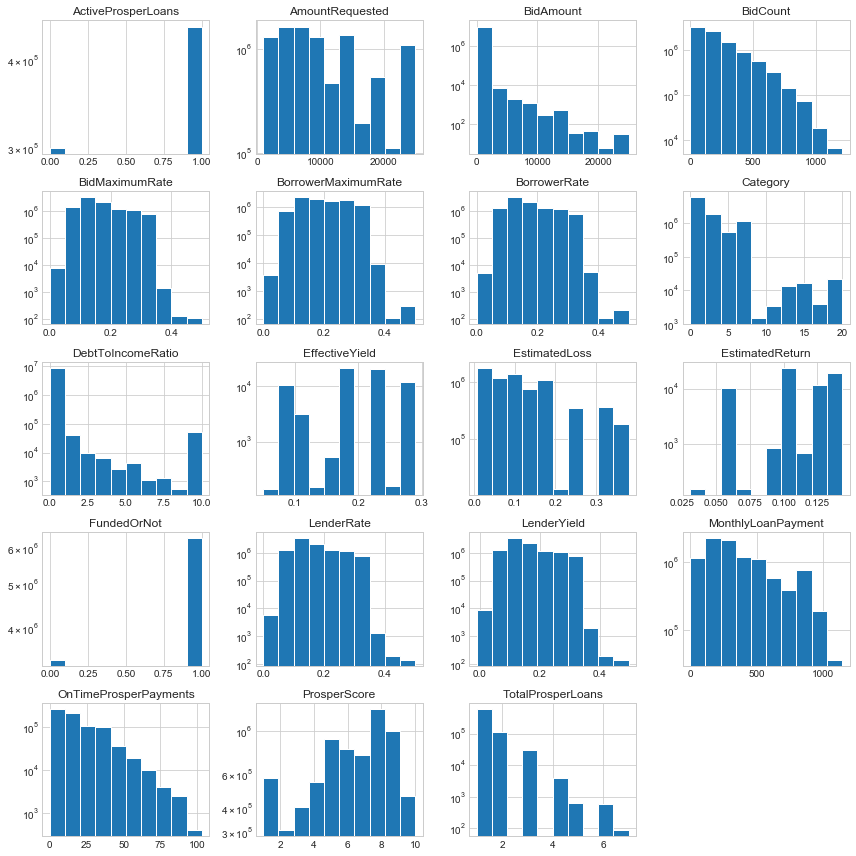

In [10]:
data.hist(figsize=(12,12), layout=(5,4), log=True)
plt.grid()
plt.tight_layout()
plt.show()

In [32]:
funding_features = ['AmountRequested',  'BidCount', 'BidMaximumRate', 'BorrowerRate', 
'BorrowerMaximumRate', 'EffectiveYield', 'DebtToIncomeRatio', 'IsBorrowerHomeowner', 'Category', 
'OnTimeProsperPayments', 'ActiveProsperLoans', 'TotalProsperLoans', 'ProsperScore']
y_funding = data['FundedOrNot']
y_funding = np.array(y_funding)
funding_class_names = np.unique(y_funding)
print "Class Names: %s" % funding_class_names


Class Names: [False  True]


In [34]:
print "\nFunding target labels:", Counter(data.FundedOrNot)


Funding target labels: Counter({True: 6300999, False: 3401716})


In [1]:
# data.loc[data['FundedOrNot']==True].fillna(False)

In [ ]:
repayment_features = funding_features
y_repayment =data.loc[data['FundedOrNot']==True]['RepaidOrNot'].fillna(False)
y_repayment = np.array(y_repayment)
repayment_class_names = np.unique(y_repayment)
print "Class Names: %s" % repayment_class_names

In [36]:
print "Classification Features: %s" % funding_features

Classification Features: ['AmountRequested', 'BidCount', 'BidMaximumRate', 'BorrowerRate', 'BorrowerMaximumRate', 'EffectiveYield', 'DebtToIncomeRatio', 'IsBorrowerHomeowner', 'Category', 'OnTimeProsperPayments', 'ActiveProsperLoans', 'TotalProsperLoans', 'ProsperScore']


In [38]:
print "Repayment target labels:", Counter(data.loc[data['FundedOrNot']==True]['RepaidOrNot'])

Repayment target labels: Counter({nan: 6177203, True: 3090657, False: 434855})


In [14]:
names = ['RBF SVM', 'Naive Bayes', 'AdaBoost', 'Neural Net', 
         'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'QDA']
print "\nClassifiers: %s" % names


Classifiers: ['RBF SVM', 'Naive Bayes', 'AdaBoost', 'Neural Net', 'Decision Tree', 'Random Forest', 'K-Nearest Neighbors', 'QDA']


In [15]:
# Construct Feature Space
funding_feature_space = data[funding_features].fillna(0)
X_funding = funding_feature_space.as_matrix().astype(np.float)
# This is Important!
scaler = StandardScaler()
X_funding = scaler.fit_transform(X_funding)
print "Feature space holds %d observations and %d features" % X_funding.shape

Feature space holds 9702715 observations and 13 features


In [16]:
# # T-Stochastic Neighborhood Embedding
# start = timeit.default_timer()
# Y = TSNE(n_components=2).fit_transform(X)
# stop = timeit.default_timer()
# print "\nEmbedded Feature space holds %d observations and %d features" % Y.shape
# print "Feature Embedding completed in %s seconds" % (stop - start)

In [17]:
# Filter important features
#filtered_features = [u'customer_autoship_active_flag', u'total_autoships', u'autoship_active', u'autoship_cancel', u'pets', u'brands']
# print "\nFiltered Features:"
# print filtered_features

In [18]:
frank_summary(X_funding, y_funding, funding_features)

,Rank,Feature,Importance,Support,x
0,1,BidMaximumRate,0.106,True,3
1,1,BorrowerRate,0.071,True,4
2,1,BorrowerMaximumRate,0.071,True,5
3,2,ProsperScore,0.287,False,13
4,3,AmountRequested,0.106,False,1
5,4,BidCount,0.159,False,2
6,5,TotalProsperLoans,0.007,False,12
7,6,Category,0.079,False,9
8,7,ActiveProsperLoans,0.010,False,11
9,8,DebtToIncomeRatio,0.082,False,7


In [19]:
logit = sm.Logit(data['FundedOrNot'], 
                 scaler.fit_transform(data[funding_features].fillna(0)))
result = logit.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.563821
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            FundedOrNot   No. Observations:              9702715
Model:                          Logit   Df Residuals:                  9702702
Method:                           MLE   Df Model:                           12
Date:                Sun, 05 Aug 2018   Pseudo R-squ.:                  0.1297
Time:                        12:21:21   Log-Likelihood:            -5.4706e+06
converged:                       True   LL-Null:                   -6.2856e+06
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.8033      0.001   -621.446      0.000      -0.806      -0.801
x2             0.7738      0.

In [20]:
# prob_plot(X_funding, y_funding) #Inspect probability distribution

In [21]:
# plot_accuracy(X, y_funding, names)